In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

/Users/a/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/a/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
PATH = '/Users/a/Desktop/lab/house_price/data/city24_export.csv'
EXPORT_TO = '/Users/a/Desktop/lab/house_price/data/city24_processed.csv'

In [3]:
df = pd.read_csv(PATH, ',')
df.shape

(10456, 26)

In [4]:
df.columns

Index(['address', 'first_image_link', 'description', 'Kinnisvara tüüp:',
       'Hind:', 'Üldpind:', 'Ehitusaasta:', 'Otseviide:', 'Lisainfo:',
       'Hind/ühik:', 'Hoone materjal:', 'Rõdu:', 'Lift:', 'Küttesüsteem:',
       'Energiamärgis:', 'Seisukord:', 'Tubade arv:', 'Magamistubade arv:',
       'Vannitubade arv:', 'Korrus/Korruseid:', 'Parkimine:', 'Sanitaar:',
       'Ventilatsioon:', 'Lisaväärtused:', 'broker_name', 'broker_company'],
      dtype='object')

Missing Data


In [5]:
all_data_na = (df.isnull().sum() / len(df)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
Lisainfo:,82.918898
Ventilatsioon:,76.836266
Lift:,69.653787
Rõdu:,52.974369
Lisaväärtused:,52.955241
Parkimine:,50.028692
Vannitubade arv:,31.446060
Magamistubade arv:,26.912777
Ehitusaasta:,25.200842
Energiamärgis:,21.470926


Text(0.5,1,'Percent missing data by feature')

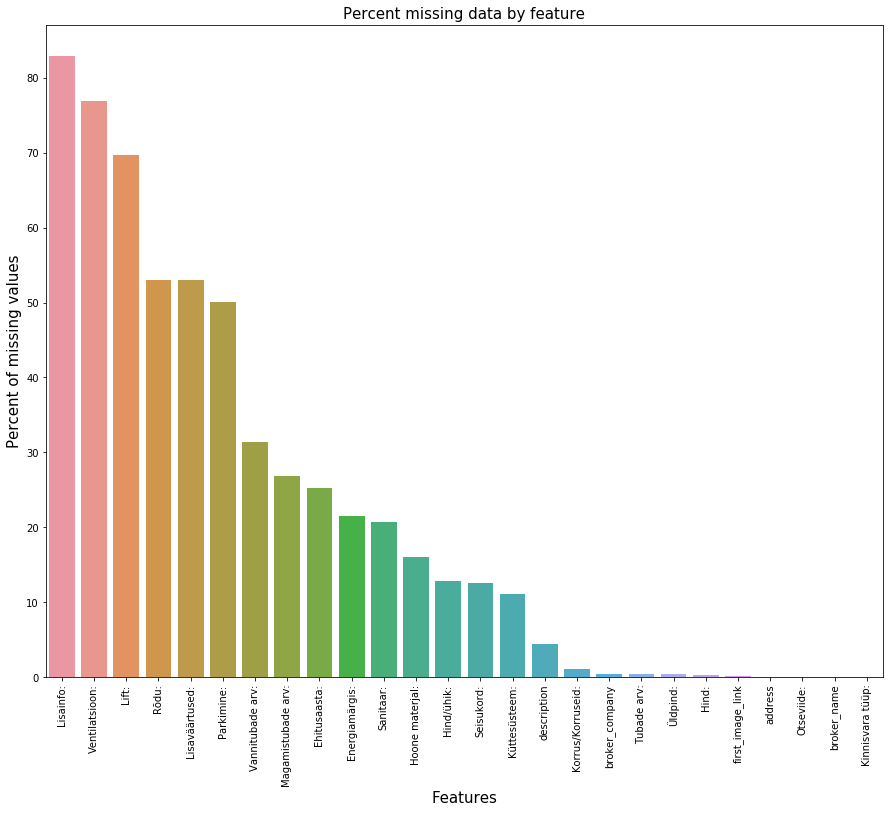

In [6]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

In [7]:
def remove_last(string):
    if ':' in string:
        return string[:-1]
    return string

def replace_space(string):
    return string.replace(' ', '_')
df.columns = df.columns.map(str.lower).map(remove_last).map(replace_space)
cols_to_remove = ['first_image_link', 'description', 'otseviide', 
                  'lisainfo', 'kinnisvara_tüüp', 'lisaväärtused', 'ventilatsioon','broker_company']
df.drop(cols_to_remove, axis=1, inplace=True)


In [8]:
df.drop(index=df[df['address'].isnull()].index, inplace=True)
df.dropna(subset=['hind','üldpind', 'tubade_arv'], inplace=True)
df.drop(['hind/ühik'], axis=1, inplace=True)
df.drop(['broker_name', 'lift'], axis=1, inplace=True)


    


In [9]:
# divide address
df_address = pd.DataFrame(df.address.str.split(',',1).tolist(),columns = ['address','city_part'])    
df_address.count()
display(df_address['address'])

0                         Ao tn 2 - 34
1                            Tartu mnt
2                              Kuninga
3                             Merirahu
4                       Ringi tn 60-26
5              Toom-Kuninga tn 21 - 34
6                       Taludevahe 116
7                              Rahumäe
8                Telliskivi tn 49 - 67
9                Telliskivi tn 49 - 28
10                          Ravi tn 14
11               Telliskivi tn 49 - 75
12                     Linnamäe tee 38
13                     Lutheri kvartal
14                            Lasnamäe
15                        Jakobi tn 15
16                Väike-Sepa tn 11 - 1
17                     Sõpruse pst 244
18                Telliskivi tn 49 - 5
19                     Linnamäe tee 12
20                    Pelguranna tn 23
21                       HEA PAKKUMINE
22                          Ümera tn 2
23                              Soprdi
24                               Ahtme
25       MÖBLEERITUD KORT

In [10]:
#divide linnaosad
kesklinn = df.loc[df['address'].str.contains('Kesklinna linnaosa')]
haabersti = df.loc[df['address'].str.contains('Haabersti linnaosa')]
kristiine = df.loc[df['address'].str.contains('Kristiine linnaosa')]
nomme = df.loc[df['address'].str.contains('Nõmme linnaosa')]
vanalinn = df.loc[df['address'].str.contains('Vanalinn')]
mustamae = df.loc[df['address'].str.contains('Mustamäe linnaosa')]
lasnamae = df.loc[df['address'].str.contains('Lasnamäe linnaosa')]
pirita = df.loc[df['address'].str.contains('Pirita linnaosa')]
pohja_tallinn = df.loc[df['address'].str.contains('Põhja-Tallinna linnaosa')]
kadriorg = df.loc[df['address'].str.contains('Kadriorg')]

frames = [kesklinn, haabersti, kristiine, nomme, vanalinn, mustamae, lasnamae, pirita, pohja_tallinn, kadriorg]
tln_df = pd.concat(frames)
tln_df.shape


(2198, 15)

In [11]:
#divide address column
def get_linnaosa(address):
    tln_parts = ['Kesklinn', 
                 'Haabersti', 
                 'Kristiine', 
                 'Nõmme', 
                 'Vanalinn', 
                 'Mustamäe', 
                 'Lasnamäe', 
                 'Pirita', 
                 'Põhja-Tallinn', 
                 'Kadriorg']
    for part in address:
        for word in tln_parts:
            if word in part:
                return word
            else:
                'Tallinn'
                            
tln_df['city_part'] = tln_df.address.str.split(',').apply(lambda x: get_linnaosa(x))
city_parts = pd.get_dummies(tln_df['city_part'])

tln_df = pd.concat([tln_df, city_parts], axis=1)
tln_df.drop(['city_part'], axis=1, inplace=True)

In [12]:
tln_df.shape

(2198, 25)

In [13]:
import re
pattern = re.compile("^[A-z-. ÄÖÜÕäöüõ]+\s+\d+")
def get_address(address):
    for part in address:
        part = part.rstrip().lstrip()
        match_obj = pattern.match(part)
        if match_obj:
            return match_obj.group()
    return np.nan

tln_df['address'] = tln_df.address.str.split(',').apply(lambda x: get_address(x))
tln_df.dropna(subset=['address'], inplace=True)


In [14]:
tln_df.count()


address              2160
hind                 2160
üldpind              2160
ehitusaasta          1772
hoone_materjal       1788
rõdu                 1222
küttesüsteem         1941
energiamärgis        1828
seisukord            1940
tubade_arv           2160
magamistubade_arv    1787
vannitubade_arv      1727
korrus/korruseid     2147
parkimine            1095
sanitaar             1745
Haabersti            2160
Kadriorg             2160
Kesklinn             2160
Kristiine            2160
Lasnamäe             2160
Mustamäe             2160
Nõmme                2160
Pirita               2160
Põhja-Tallinn        2160
Vanalinn             2160
dtype: int64

In [15]:
# hind column cleaning from EUR
def clean_numeric_value(row):
    row = row.strip(' ')
    numeric = re.sub(r'\D', "", row)
    return numeric
tln_df['hind'] = tln_df['hind'].apply(lambda x: clean_numeric_value(x))

# change type of hind column
tln_df['hind'] = tln_df['hind'].astype(int)
tln_df.dtypes

address               object
hind                   int64
üldpind               object
ehitusaasta          float64
hoone_materjal        object
rõdu                  object
küttesüsteem          object
energiamärgis         object
seisukord             object
tubade_arv           float64
magamistubade_arv    float64
vannitubade_arv      float64
korrus/korruseid      object
parkimine             object
sanitaar              object
Haabersti              uint8
Kadriorg               uint8
Kesklinn               uint8
Kristiine              uint8
Lasnamäe               uint8
Mustamäe               uint8
Nõmme                  uint8
Pirita                 uint8
Põhja-Tallinn          uint8
Vanalinn               uint8
dtype: object

In [16]:
#clean uldpind from m and convert to float
def clean_floating_value(row):
    row = row.strip(' ')
    floating = re.sub(r'[+-]?([0-9]*[.])?[0-9]+', "", row)
    return floating

tln_df['üldpind'] = tln_df['üldpind'].str.split(' ').apply(lambda x: x[0])
tln_df['üldpind'] = tln_df['üldpind'].astype(float)


In [17]:
# clean ehitusaasta column
#add to parnu mnt 69 value of 1911 according to the information in the web
tln_df.loc[tln_df['address'].str.contains('Pärnu mnt 69'),'ehitusaasta'] = 1911

In [18]:
tln_df[tln_df['ehitusaasta'].isnull()].shape

(369, 25)

In [19]:
# find same house objects that have ehitusaasta column aggregate the major value and assign
# null_year_address_list = tln_df[tln_df['ehitusaasta'].isnull()]['address'].tolist()
# for address in null_year_address_list:
#     year_isnotna = tln_df['ehitusaasta'].notnull()
#     has_addr = tln_df['address'] == address
#     found_year = tln_df[year_isnotna & has_addr]
#     if not found_year.empty:
#         found = found_year['ehitusaasta'].value_counts().index[0]
#         tln_df.loc[tln_df['address'] == address, 'ehitusaasta'] = found
# tln_df[tln_df['ehitusaasta'].isnull()].shape


In [20]:
def extract_column_from_similar_object(address_list_with_nan, nan_column, df):
    for address in address_list_with_nan:
        column_with_notna = df[nan_column].notnull()
        has_addr = df['address'] == address
        found_similar = df[column_with_notna & has_addr]
        if not found_similar.empty:
            found = found_similar[nan_column].value_counts().index[0]
            df.loc[df['address'] == address, nan_column] = found

In [21]:
# find same house objects that have ehitusaasta column aggregate the major value and assign
null_year_address_list = tln_df[tln_df['ehitusaasta'].isnull()]['address'].tolist()
extract_column_from_similar_object(null_year_address_list, 'ehitusaasta', tln_df)
tln_df[tln_df['ehitusaasta'].isnull()].shape

(278, 25)

In [22]:
# assign average ehitusaasta column value to nans
tallinn_average_build_year = tln_df[tln_df['ehitusaasta'].notnull()]['ehitusaasta'].mean()
display(tallinn_average_build_year)
tln_df.loc[tln_df['ehitusaasta'].isnull(), 'ehitusaasta'] = tallinn_average_build_year
tln_df[tln_df['ehitusaasta'].isnull()].shape

#change ehitusaasta column dtype
tln_df['ehitusaasta'] = tln_df['ehitusaasta'].astype(int)


1993.4187035069076

In [23]:
# extract terrass column because it may have influence on the price
tln_df['terrass'] = np.nan
tln_df.loc[tln_df['rõdu'].str.contains('terrass', na=False), 'terrass'] = 'terrass'
# remove old column and merge new
tln_df['terrass'] = pd.get_dummies(tln_df['terrass'])
tln_df.count()
# leave it now but probably later will 
# decide not to use it as it have small amount that will not improve model


address              2160
hind                 2160
üldpind              2160
ehitusaasta          2160
hoone_materjal       1788
rõdu                 1222
küttesüsteem         1941
energiamärgis        1828
seisukord            1940
tubade_arv           2160
magamistubade_arv    1787
vannitubade_arv      1727
korrus/korruseid     2147
parkimine            1095
sanitaar             1745
Haabersti            2160
Kadriorg             2160
Kesklinn             2160
Kristiine            2160
Lasnamäe             2160
Mustamäe             2160
Nõmme                2160
Pirita               2160
Põhja-Tallinn        2160
Vanalinn             2160
terrass              2160
dtype: int64

In [24]:
# clean rõdu column to have only true or false value indicating house has balcony or not
tln_df.loc[tln_df['rõdu'].str.contains('rõdu', na=False), 'rõdu'] = 'rõdu'
has_balcony_df = pd.get_dummies(tln_df['rõdu'])
has_balcony_df.drop(['terrass'], axis=1, inplace=True)
# remove old column and merge new
tln_df['rõdu'] = has_balcony_df
display(tln_df)

,address,hind,üldpind,ehitusaasta,hoone_materjal,rõdu,küttesüsteem,energiamärgis,seisukord,tubade_arv,...,Kadriorg,Kesklinn,Kristiine,Lasnamäe,Mustamäe,Nõmme,Pirita,Põhja-Tallinn,Vanalinn,terrass
0,Ao tn 2,649800,148.3,2018,kivimaja,1,"keskküte, põrandaküte",b,uusehitis,4.0,...,0,1,0,0,0,0,0,0,0,1
10,Ravi tn 14,190000,154.2,2004,paneelmaja,1,elektriküte,d,remonti vajav,5.0,...,0,1,0,0,0,0,0,0,0,0
13,Pärnu mnt 69,75000,14.9,1911,kivimaja,0,keskküte,b,renoveeritud,1.0,...,0,1,0,0,0,0,0,0,0,0
15,Jakobi tn 15,77900,36.9,1960,kivimaja,0,keskküte,NaN,"renoveeritud, uus viimistlus, valmis",1.0,...,0,1,0,0,0,0,0,0,0,0
33,Narva mnt 9,165000,76.0,1958,kivimaja,0,keskküte,Energiamärgis puudub,"renoveeritud, valmis",3.0,...,0,1,0,0,0,0,0,0,0,0
35,Tartu mnt 52,209900,79.5,2017,paneelmaja,1,põrandaküte,b,uusehitis,3.0,...,0,1,0,0,0,0,0,0,0,0
38,Tina 13,125000,64.6,1963,kivimaja,1,keskküte,d,san remont tehtud,3.0,...,0,1,0,0,0,0,0,0,0,0
40,Pärnu mnt 69,119000,39.2,1911,kivimaja,0,keskküte,b,renoveeritud,2.0,...,0,1,0,0,0,0,0,0,0,0
51,Vesivärava tn 50,269500,105.4,2019,NaN,1,"keskküte, põrandaküte",b,uusehitis,4.0,...,0,1,0,0,0,0,0,0,0,0
52,Rävala pst 11,65000,25.9,1951,kivimaja,0,keskküte,d,NaN,1.0,...,0,1,0,0,0,0,0,0,0,0


In [25]:
tln_df.count()
tln_df.dtypes


address               object
hind                   int64
üldpind              float64
ehitusaasta            int64
hoone_materjal        object
rõdu                   uint8
küttesüsteem          object
energiamärgis         object
seisukord             object
tubade_arv           float64
magamistubade_arv    float64
vannitubade_arv      float64
korrus/korruseid      object
parkimine             object
sanitaar              object
Haabersti              uint8
Kadriorg               uint8
Kesklinn               uint8
Kristiine              uint8
Lasnamäe               uint8
Mustamäe               uint8
Nõmme                  uint8
Pirita                 uint8
Põhja-Tallinn          uint8
Vanalinn               uint8
terrass                uint8
dtype: object

In [26]:
tln_df[tln_df['küttesüsteem'].isnull()].shape

(219, 26)

In [27]:
null_heating_address_list = tln_df[tln_df['küttesüsteem'].isnull()]['address'].tolist()
extract_column_from_similar_object(null_heating_address_list, 'küttesüsteem', tln_df)
tln_df[tln_df['küttesüsteem'].isnull()].shape


(152, 26)

In [28]:
most_popular_heating = tln_df['küttesüsteem'].value_counts().index[0]
tln_df['küttesüsteem'].fillna(most_popular_heating, inplace=True)
tln_df[tln_df['küttesüsteem'].isnull()].shape

(0, 26)

In [29]:
# extracting küttesüsteem column into categorical values
unique_heating_types = set()
def extract_unique(row, unique_set):
    for el in row.split(','):
        el = el.lstrip().rstrip()
        unique_set.add(el)
tln_df['küttesüsteem'].apply(lambda x: extract_unique(x, unique_heating_types))

for heating in unique_heating_types:
    tln_df[heating] = np.nan
    tln_df.loc[tln_df['küttesüsteem'].str.contains(heating), heating] = heating
    tln_df[heating] = pd.get_dummies(tln_df[heating])
tln_df.drop(['küttesüsteem'], axis=1, inplace=True)
tln_df.shape        


(2160, 36)

In [30]:
# replace nan values with popular value
tln_df['hoone_materjal'] = tln_df['hoone_materjal'].fillna(tln_df['hoone_materjal'].mode()[0])


In [31]:
unique_house_material_types = set()

tln_df['hoone_materjal'].apply(lambda x: extract_unique(x, unique_house_material_types))
for material in unique_house_material_types:
    tln_df[material] = np.nan
    tln_df.loc[tln_df['hoone_materjal'].str.contains(material), material] = material
    tln_df[material] = pd.get_dummies(tln_df[material])
tln_df.drop(['hoone_materjal'], axis=1, inplace=True)
tln_df.shape

(2160, 42)

In [32]:
tln_df[tln_df['energiamärgis'].isnull()].shape
tln_df.dtypes

address                object
hind                    int64
üldpind               float64
ehitusaasta             int64
rõdu                    uint8
energiamärgis          object
seisukord              object
tubade_arv            float64
magamistubade_arv     float64
vannitubade_arv       float64
korrus/korruseid       object
parkimine              object
sanitaar               object
Haabersti               uint8
Kadriorg                uint8
Kesklinn                uint8
Kristiine               uint8
Lasnamäe                uint8
Mustamäe                uint8
Nõmme                   uint8
Pirita                  uint8
Põhja-Tallinn           uint8
Vanalinn                uint8
terrass                 uint8
elektriküte             uint8
gaasiküte               uint8
ahjuküte                uint8
maaküte                 uint8
autnoomne küte          uint8
tahkekütus              uint8
keskküte                uint8
õhksoojuspump           uint8
kamin                   uint8
põrandaküt

In [33]:
# processing energiamärgis column
null_energy_mark_address_list = tln_df[tln_df['energiamärgis'].isnull()]['address'].tolist()
extract_column_from_similar_object(null_energy_mark_address_list, 'energiamärgis', tln_df)

tln_df.loc[tln_df['energiamärgis'].isnull(), 'energiamärgis'] = 'b'
tln_df.loc[tln_df['energiamärgis'] == 'Energiamärgis puudub', 'energiamärgis'] = 'b'
energy_classes = pd.get_dummies(tln_df['energiamärgis'], prefix='energy_class')

tln_df = pd.concat([tln_df, energy_classes], axis=1)

tln_df.drop(['energiamärgis'], axis=1, inplace=True)

In [34]:
tln_df.columns
tln_df.dtypes

address                object
hind                    int64
üldpind               float64
ehitusaasta             int64
rõdu                    uint8
seisukord              object
tubade_arv            float64
magamistubade_arv     float64
vannitubade_arv       float64
korrus/korruseid       object
parkimine              object
sanitaar               object
Haabersti               uint8
Kadriorg                uint8
Kesklinn                uint8
Kristiine               uint8
Lasnamäe                uint8
Mustamäe                uint8
Nõmme                   uint8
Pirita                  uint8
Põhja-Tallinn           uint8
Vanalinn                uint8
terrass                 uint8
elektriküte             uint8
gaasiküte               uint8
ahjuküte                uint8
maaküte                 uint8
autnoomne küte          uint8
tahkekütus              uint8
keskküte                uint8
õhksoojuspump           uint8
kamin                   uint8
põrandaküte             uint8
kombineeri

In [35]:
tln_df[tln_df['seisukord'].isnull()].shape



(220, 48)

In [36]:
tln_df.loc[tln_df['ehitusaasta'] >= 2017, 'seisukord'] = 'uusehitis'
tln_df.loc[tln_df['seisukord'].isnull(), 'seisukord'] = 'valmis'
tln_df[tln_df['seisukord'].isnull()].shape


(0, 48)

In [37]:
unique_house_conditions = set()
tln_df['seisukord'].apply(lambda x: extract_unique(x, unique_house_conditions))
unique_house_conditions


{'kap. remonti vajav',
 'remonti vajav',
 'renoveeritud',
 'san remont tehtud',
 'uus viimistlus',
 'uusehitis',
 'valmimisjärgus',
 'valmis'}

In [38]:
# i decide to estimate condition by using next classes [A,B,C]
# A - new
# B - ready
# C - requires fixes
# make dictionary with unique_house_conditions
house_condition = {'A':['uusehitis'], 'B':['uus viimistlus', 'valmis', 'san remont tehtud', 'renoveeritud'], 'C':['remonti vajav', 'valmimisjärgus', 'kap. remonti vajav']}
def estimate_house_condition(row):
    weights = {'A':3, 'B':2, 'C':1}
    resulting_estimation = 'A'
    for mark, conditions in house_condition.items():
        for condition in conditions:
            if condition in row:
                if weights.get(resulting_estimation) > weights.get(mark):
                    resulting_estimation = mark
    return resulting_estimation
tln_df['seisukord'] = tln_df['seisukord'].apply(lambda x: estimate_house_condition(x))

# lets give seisukord column some ordinal value
tln_df.loc[tln_df['seisukord'] == 'A', 'seisukord'] = '1'
tln_df.loc[tln_df['seisukord'] == 'B', 'seisukord'] = '2'
tln_df.loc[tln_df['seisukord'] == 'C', 'seisukord'] = '3'
tln_df['seisukord'] = tln_df['seisukord'].astype(int)

display(tln_df)
            

,address,hind,üldpind,ehitusaasta,rõdu,seisukord,tubade_arv,magamistubade_arv,vannitubade_arv,korrus/korruseid,...,plokkmaja,palk-kivimaja,puitmaja,energy_class_a,energy_class_b,energy_class_c,energy_class_d,energy_class_e,energy_class_f,energy_class_g
0,Ao tn 2,649800,148.3,2018,1,1,4.0,3.0,3.0,5 / 5,...,0,0,0,0,1,0,0,0,0,0
10,Ravi tn 14,190000,154.2,2004,1,3,5.0,4.0,2.0,4 / 5,...,0,0,0,0,0,0,1,0,0,0
13,Pärnu mnt 69,75000,14.9,1911,0,2,1.0,1.0,1.0,2 / 3,...,0,0,0,0,1,0,0,0,0,0
15,Jakobi tn 15,77900,36.9,1960,0,2,1.0,1.0,1.0,2 / 4,...,0,0,0,0,0,0,0,0,1,0
33,Narva mnt 9,165000,76.0,1958,0,2,3.0,3.0,1.0,5 / 7,...,0,0,0,0,1,0,0,0,0,0
35,Tartu mnt 52,209900,79.5,2017,1,1,3.0,2.0,1.0,5 / 5,...,0,0,0,0,1,0,0,0,0,0
38,Tina 13,125000,64.6,1963,1,2,3.0,2.0,1.0,1 / 5,...,0,0,0,0,0,0,1,0,0,0
40,Pärnu mnt 69,119000,39.2,1911,0,2,2.0,1.0,1.0,2 / 3,...,0,0,0,0,1,0,0,0,0,0
51,Vesivärava tn 50,269500,105.4,2019,1,1,4.0,3.0,2.0,9 / 6,...,0,0,0,0,1,0,0,0,0,0
52,Rävala pst 11,65000,25.9,1951,0,2,1.0,1.0,1.0,1 / 5,...,0,0,0,0,0,0,1,0,0,0


In [39]:
# decided to remove 'magamistubade_arv', 'vannitubade_arv' columns
# as they does not improve model much
tln_df['tubade_arv'] = tln_df['tubade_arv'].astype(int)
tln_df.drop(['magamistubade_arv', 'vannitubade_arv'], axis=1, inplace=True)


In [40]:
tln_df.count()

address               2160
hind                  2160
üldpind               2160
ehitusaasta           2160
rõdu                  2160
seisukord             2160
tubade_arv            2160
korrus/korruseid      2147
parkimine             1095
sanitaar              1745
Haabersti             2160
Kadriorg              2160
Kesklinn              2160
Kristiine             2160
Lasnamäe              2160
Mustamäe              2160
Nõmme                 2160
Pirita                2160
Põhja-Tallinn         2160
Vanalinn              2160
terrass               2160
elektriküte           2160
gaasiküte             2160
ahjuküte              2160
maaküte               2160
autnoomne küte        2160
tahkekütus            2160
keskküte              2160
õhksoojuspump         2160
kamin                 2160
põrandaküte           2160
kombineeritud küte    2160
betoonmaja            2160
paneelmaja            2160
kivimaja              2160
palkmaja              2160
plokkmaja             2160
p

In [41]:
null_house_floor_address_list = tln_df[tln_df['korrus/korruseid'].isnull()]['address'].tolist()
extract_column_from_similar_object(null_house_floor_address_list, 'korrus/korruseid', tln_df)
tln_df['korrus/korruseid'].fillna(tln_df['korrus/korruseid'].value_counts().index[0], inplace=True)


In [42]:
# extract korrus from korrus/korruseid column
tln_df['korrus/korruseid'] = tln_df['korrus/korruseid'].str.replace('-','/')
tln_df['korrus'] = tln_df['korrus/korruseid'].str.strip().str[0]
#change type of korrus column to numeric
wrong_korrus = tln_df['korrus'] == '/'
most_common_value = tln_df['korrus'].value_counts().index[0]
tln_df.loc[wrong_korrus, 'korrus'] = most_common_value
tln_df['korrus'] = tln_df['korrus'].astype(int)
tln_df.drop(['korrus/korruseid'], axis=1, inplace=True)



In [43]:
# remove parkimine column because half of the values are missed
tln_df.drop(['parkimine'], axis=1, inplace=True)

In [44]:
# extract specific features like pool, sauna and etc..
tln_df.loc[tln_df['sanitaar'].isnull(), 'sanitaar'] = 'dušš'
tln_df['saun'] = np.nan
has_saun = tln_df['sanitaar'].str.contains('saun')
tln_df.loc[has_saun, 'saun'] = 'saun'
tln_df['saun'] = pd.get_dummies(tln_df['saun'])

tln_df['bassein'] = np.nan
tln_df.loc[tln_df['sanitaar'].str.contains('bassein'), 'bassein'] = 'bassein'
tln_df['bassein'] = pd.get_dummies(tln_df['bassein'])

tln_df.drop(['sanitaar'], axis=1, inplace=True)

In [45]:
tln_df.columns

Index(['address', 'hind', 'üldpind', 'ehitusaasta', 'rõdu', 'seisukord',
       'tubade_arv', 'Haabersti', 'Kadriorg', 'Kesklinn', 'Kristiine',
       'Lasnamäe', 'Mustamäe', 'Nõmme', 'Pirita', 'Põhja-Tallinn', 'Vanalinn',
       'terrass', 'elektriküte', 'gaasiküte', 'ahjuküte', 'maaküte',
       'autnoomne küte', 'tahkekütus', 'keskküte', 'õhksoojuspump', 'kamin',
       'põrandaküte', 'kombineeritud küte', 'betoonmaja', 'paneelmaja',
       'kivimaja', 'palkmaja', 'plokkmaja', 'palk-kivimaja', 'puitmaja',
       'energy_class_a', 'energy_class_b', 'energy_class_c', 'energy_class_d',
       'energy_class_e', 'energy_class_f', 'energy_class_g', 'korrus', 'saun',
       'bassein'],
      dtype='object')

In [46]:

tln_df.to_csv(EXPORT_TO, encoding='utf-8')
tln_df


,address,hind,üldpind,ehitusaasta,rõdu,seisukord,tubade_arv,Haabersti,Kadriorg,Kesklinn,...,energy_class_a,energy_class_b,energy_class_c,energy_class_d,energy_class_e,energy_class_f,energy_class_g,korrus,saun,bassein
0,Ao tn 2,649800,148.3,2018,1,1,4,0,0,1,...,0,1,0,0,0,0,0,5,1,0
10,Ravi tn 14,190000,154.2,2004,1,3,5,0,0,1,...,0,0,0,1,0,0,0,4,1,0
13,Pärnu mnt 69,75000,14.9,1911,0,2,1,0,0,1,...,0,1,0,0,0,0,0,2,0,0
15,Jakobi tn 15,77900,36.9,1960,0,2,1,0,0,1,...,0,0,0,0,0,1,0,2,0,0
33,Narva mnt 9,165000,76.0,1958,0,2,3,0,0,1,...,0,1,0,0,0,0,0,5,0,0
35,Tartu mnt 52,209900,79.5,2017,1,1,3,0,0,1,...,0,1,0,0,0,0,0,5,0,0
38,Tina 13,125000,64.6,1963,1,2,3,0,0,1,...,0,0,0,1,0,0,0,1,0,0
40,Pärnu mnt 69,119000,39.2,1911,0,2,2,0,0,1,...,0,1,0,0,0,0,0,2,0,0
51,Vesivärava tn 50,269500,105.4,2019,1,1,4,0,0,1,...,0,1,0,0,0,0,0,9,0,0
52,Rävala pst 11,65000,25.9,1951,0,2,1,0,0,1,...,0,0,0,1,0,0,0,1,0,0


In [47]:
tln_df['korrus'].unique()

array([5, 4, 2, 1, 9, 3, 6, 7, 0, 8])